In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score

import FeatureGenerator as fg

from lightgbm import LGBMClassifier

In [2]:
data_path = "../inputs/train.csv"
df_train = pd.read_csv(data_path)
df_train.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,28104,50000.0,2,1,1,31,1,2,2,0,...,50332.0,29690.0,30246.0,2200.0,4.0,2300.0,1100.0,1400.0,1200.0,1
1,29094,330000.0,2,2,2,59,0,0,0,0,...,80589.0,76180.0,61693.0,20000.0,3500.0,19000.0,15000.0,3000.0,2139.0,0
2,11280,220000.0,2,1,2,41,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,28435,50000.0,2,2,1,45,0,0,0,0,...,8469.0,8411.0,8361.0,2124.0,2037.0,1130.0,295.0,302.0,296.0,0
4,10873,480000.0,2,3,1,42,-2,-2,-2,-2,...,0.0,790.0,0.0,0.0,0.0,0.0,790.0,0.0,0.0,0


In [3]:
#selecionando as variáveis categóricas para definir no modelo
cat_cols = ['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [4]:
selected_features = ['BILL_AMT2_minus_BILL_AMT1',
 'PAY_AMT5/BILL_AMT5',
 'PAY_AMT6/BILL_AMT6',
 'BILL_AMT3_minus_BILL_AMT2',
 'PAY_AMT4/BILL_AMT4',
 'PAY_AMT1/BILL_AMT1',
 'PAY_AMT4_minus_PAY_AMT3',
 'PAY_AMT2/BILL_AMT2',
 'BILL_AMT5_minus_BILL_AMT4',
 'BILL_AMT4_minus_BILL_AMT3',
 'AGE',
 'BILL_AMT6_minus_BILL_AMT5',
 'PAY_AMT3/BILL_AMT3',
 'PAY_AMT2_minus_PAY_AMT1',
 'PAY_AMT6_minus_PAY_AMT5',
 'PAY_AMT5_minus_PAY_AMT4',
 'LIMIT_BAL/EDUCATION_max',
 'PAY_AMT2',
 'PAY_AMT3_minus_PAY_AMT2',
 'LIMIT_BAL/EDUCATION_mean',
 'PAY_AMT1',
 'BILL_AMT5/EDUCATION_min',
 'LIMIT_BAL',
 'PAY_AMT6',
 'PAY_0',
 'PAY_AMT3',
 'PAY_AMT4',
 'BILL_AMT1',
 'PAY_AMT5',
 'BILL_AMT1/EDUCATION_max',
 'BILL_AMT4/EDUCATION_min',
 'BILL_AMT2/EDUCATION_min',
 'BILL_AMT3/EDUCATION_min',
 'BILL_AMT6/EDUCATION_min']

In [5]:
#inicializando as classes que serão utilizadas para geração de features
fbf = fg.FeatureByFeature(features_num=["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"],
                         features_denom=["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"])

diff1 = fg.DiffFeatures(features=["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"])

diff2 = fg.DiffFeatures(features=["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"])

agpf = fg.GroupFeatures(group_columns=["EDUCATION"], features=["LIMIT_BAL", "BILL_AMT1", 
                                                               "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", 
                                                               "BILL_AMT5", "BILL_AMT6"])
final_features = fg.FinalFeatures(features=selected_features)

In [6]:
X_train, y_train = df_train.drop(columns=["ID", "target"], axis=1), df_train.target.values

In [7]:
base_estimator = LGBMClassifier(class_weight="balanced",
                               random_state=42)

In [8]:
pipe = Pipeline(steps=[("FeatureByFeature", fbf),
                      ("diff_features1", diff1),
                      ("diff_features2", diff2),
                      ("aggrouped_features", agpf),
                      ("FinalFeatures", final_features),
                      ("Estimator", base_estimator)])

In [9]:
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
print(cross_val_score(pipe, X_train, y_train, cv=cross_val, scoring="f1"))

[0.54968492 0.50482625 0.53438662 0.53012048 0.55875183]


In [11]:
print(np.mean([0.54545455, 0.51622566, 0.53697598, 0.50964869, 0.54563394]))

0.530787764


In [12]:
distributions = {"Estimator__n_estimators": [100, 200, 300, 500, 650, 800, 1000, 1200, 1600, 2000],
                "Estimator__colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, None],
                "Estimator__max_depth": [2, 4, 6, 8, 10, 12, 16, None],
                "Estimator__num_leaves": [8, 10, 12, 16, 20, 31, 41, 51, 61],
                "Estimator__min_child_samples": [20, 30, 40, 50, 60, 80, 100],
                "Estimator__reg_alpha": [2, 4, 6, 8, 10, 12, 16],
                "Estimator__reg_lambda": [2, 4, 6, 8, 10, 12, 16],
                "Estimator__learning_rate": [0.3, 0.1, 0.08, 0.06, 0.04, 0.03, 0.02, 0.01, 0.008, 0.005]}

In [13]:
clf = RandomizedSearchCV(pipe, distributions, cv=cross_val, scoring="f1")

In [14]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('FeatureByFeature',
                                              FeatureByFeature(features_denom=['BILL_AMT1',
                                                                               'BILL_AMT2',
                                                                               'BILL_AMT3',
                                                                               'BILL_AMT4',
                                                                               'BILL_AMT5',
                                                                               'BILL_AMT6'],
                                                               features_num=['PAY_AMT1',
                                                                             'PAY_AMT2',
                                                                             'PAY_AMT3',
                                

In [15]:
results = pd.DataFrame(clf.cv_results_)
results = results.sort_values(by="rank_test_score", ascending=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Estimator__reg_lambda,param_Estimator__reg_alpha,param_Estimator__num_leaves,param_Estimator__n_estimators,param_Estimator__min_child_samples,param_Estimator__max_depth,...,param_Estimator__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,2.561758,0.024049,0.163403,0.019012,10,2,12,800,40,2,...,None,"{'Estimator__reg_lambda': 10, 'Estimator__reg_...",0.549685,0.504826,0.534387,0.530120,0.558752,0.535554,0.018509,1
5,3.122867,0.012904,0.229749,0.007880,12,6,16,500,100,None,...,0.4,"{'Estimator__reg_lambda': 12, 'Estimator__reg_...",0.556341,0.512649,0.533875,0.522145,0.551433,0.535289,0.016680,2
7,0.902636,0.025363,0.094528,0.014297,12,10,16,100,20,12,...,0.5,"{'Estimator__reg_lambda': 12, 'Estimator__reg_...",0.550503,0.519828,0.542558,0.519077,0.542723,0.534938,0.012968,3


In [16]:
clf.best_params_

{'Estimator__reg_lambda': 10,
 'Estimator__reg_alpha': 2,
 'Estimator__num_leaves': 12,
 'Estimator__n_estimators': 800,
 'Estimator__min_child_samples': 40,
 'Estimator__max_depth': 2,
 'Estimator__learning_rate': 0.02,
 'Estimator__colsample_bytree': None}

In [17]:
selected_params = {'reg_lambda': 10,
 'reg_alpha': 2,
 'num_leaves': 12,
 'n_estimators': 800,
 'min_child_samples': 40,
 'max_depth': 2,
 'learning_rate': 0.02,
 'colsample_bytree': None}

In [18]:
estimator = LGBMClassifier(**selected_params,
                           class_weight="balanced",
                           random_state=42)

In [19]:
pipe = Pipeline(steps=[("FeatureByFeature", fbf),
                      ("diff_features1", diff1),
                      ("diff_features2", diff2),
                      ("aggrouped_features", agpf),
                      ("FinalFeatures", final_features),
                      ("Estimator", estimator)])

In [21]:
print(cross_val_score(pipe, X_train, y_train, cv=cross_val, scoring="f1"))

[0.54968492 0.50482625 0.53438662 0.53012048 0.55875183]


In [22]:
print(np.mean([0.54968492, 0.50482625, 0.53438662, 0.53012048, 0.55875183]))

0.53555402


In [23]:
def prob2class(value, thresh):
    if value > thresh:
        return 1
    else:
        return 0

In [25]:
eval_set = pd.read_csv("../inputs/validation.csv")

In [26]:
X_val, y_val = eval_set.drop(columns="target", axis=1), eval_set.target.values

In [28]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('FeatureByFeature',
                 FeatureByFeature(features_denom=['BILL_AMT1', 'BILL_AMT2',
                                                  'BILL_AMT3', 'BILL_AMT4',
                                                  'BILL_AMT5', 'BILL_AMT6'],
                                  features_num=['PAY_AMT1', 'PAY_AMT2',
                                                'PAY_AMT3', 'PAY_AMT4',
                                                'PAY_AMT5', 'PAY_AMT6'])),
                ('diff_features1',
                 DiffFeatures(features=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                                        'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])),
                ('diff_features...
                                         'LIMIT_BAL/EDUCATION_mean', 'PAY_AMT1',
                                         'BILL_AMT5/EDUCATION_min', 'LIMIT_BAL',
                                         'PAY_AMT6', 'PAY_0', 'PAY_AMT3',
                                         'PAY_AMT4', '

In [50]:
y_proba = pipe.predict_proba(X_val)
y_proba = [p[1] for p in y_proba]
X_val["probability"] = y_proba

In [51]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
f1s = []

In [52]:
for t in thresholds:
    X_val["prediction"] = X_val.apply(lambda x: prob2class(x["probability"], thresh=t), axis=1)
    y_pred = X_val["prediction"].values
    
    f1 = f1_score(y_val, y_pred)
    f1s.append(f1)

Text(0.5, 1.0, 'Threshold selection for f1_score')

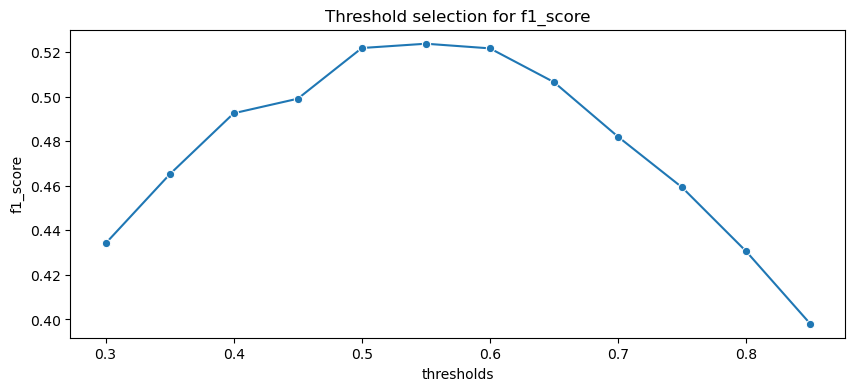

In [54]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=thresholds, y=f1s, marker='o')
plt.xlabel("thresholds")
plt.ylabel("f1_score")
plt.title("Threshold selection for f1_score")